# Training a NN for metric on CICY with homog

## Import the required packages/functions

In [29]:
#disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [30]:
import numpy as np
import gc
import sys
import os
import re
import logging
import pickle
import sys
#sys.path.append("/Users/kit/Documents/Phys_Working/MF metric")
#sys.path.append("/home/f/fraser-talientec/PhysicalYukawas")
sys.path.append("/home/f/fraser-talientec/cymetricap/AlphaPrime")

logging.basicConfig(stream=sys.stdout)

from cymetric.pointgen.pointgen import PointGenerator
from cymetric.pointgen.nphelper import prepare_dataset, prepare_basis_pickle
from cymetric.config import real_dtype, complex_dtype, set_double_precision

import tensorflow as tf
import tensorflow.keras as tfk
# Set TensorFlow to use 64-bit floating point precision
#tf.keras.backend.set_floatx('float64')
#tf.keras.mixed_precision.set_global_policy('float32')
#tf.keras.backend.set_floatx('float32')
set_double_precision(False)



tf.get_logger().setLevel('ERROR')


from cymetric.models.tfmodels import PhiFSModel, MultFSModel, FreeModel, MatrixFSModel, AddFSModel, PhiFSModelToric, MatrixFSModelToric
from cymetric.models.tfhelper import prepare_tf_basis, train_model
from cymetric.models.callbacks import SigmaCallback, KaehlerCallback, TransitionCallback, RicciCallback, VolkCallback, AlphaCallback
from cymetric.models.metrics import SigmaLoss, KaehlerLoss, TransitionLoss, RicciLoss, VolkLoss, TotalLoss

from NewCustomMetrics import *
from laplacian_funcs import *
#from generate_and_train_all_nnsHOLO import *
from custom_networks import *
import sys
import importlib
from AlphaPrimeModel import *
#reimport ALphaPrimeModel
importlib.reload(sys.modules['AlphaPrimeModel'])
from AlphaPrimeModel import *
#reimport custom_networks
importlib.reload(sys.modules['custom_networks'])
from custom_networks import *

importlib.reload(sys.modules['laplacian_funcs'])
from laplacian_funcs import *



In [31]:
import sys
import logging

so = open("dataDevLapl2.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

## Point Cloud Generation

In [32]:

def create_adam_optimizer_with_decay(initial_learning_rate, nEpochs, final_lr_factor=10):
    """
    Creates an Adam optimizer with exponential learning rate decay.

    Parameters:
    - initial_learning_rate: The starting learning rate
    - nEpochs: The number of epochs over which to decay the learning rate
    - final_lr_factor: The factor by which to reduce the learning rate (default: 10)

    Returns:
    - An Adam optimizer with the specified learning rate decay
    """
    decay_rate = (1/final_lr_factor) ** (1/nEpochs)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1,
        decay_rate=decay_rate,
        staircase=False
    )

    return tf.keras.optimizers.Adam(learning_rate=lr_schedule)

def generate_points_and_save_using_defaults(free_coefficient,number_points,force_generate=False,seed_set=0):
   coefficients=coefficientsTQ
   # coefficients=np.array([1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, \
   # 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, free_coefficient, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1])
   monomials=monomialsTQ
   kmoduli=kmoduliTQ
   ambient=ambientTQ
   pg = PointGenerator(monomials, coefficients, kmoduli, ambient)
   pg._set_seed(seed_set)
   #dirname = 'data/tetraquadric_pg_wit#h_'+str(free_coefficient)
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   print("dirname: " + dirname)
   #test if the directory exists, if not, create it
   if force_generate or (not os.path.exists(dirname)):
      print("Generating: forced? " + str(force_generate))
      kappa = pg.prepare_dataset(number_points, dirname)
      pg.prepare_basis(dirname, kappa=kappa)
   elif os.path.exists(dirname):
      try:
         print("loading prexisting dataset")
         data = np.load(os.path.join(dirname, 'dataset.npz'))
         if (len(data['X_train'])+len(data['X_val']))!=number_points:
            print("wrong length - generating anyway")
            kappa = pg.prepare_dataset(number_points, dirname)
            pg.prepare_basis(dirname, kappa=kappa)
      except:
         print("error loading - generating anyway")
         kappa = pg.prepare_dataset(number_points, dirname)
         pg.prepare_basis(dirname, kappa=kappa)


def getcallbacksandmetrics(data):
   #rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
   scb = SigmaCallback((data['X_val'], data['y_val']))
   volkcb = VolkCallback((data['X_val'], data['y_val']))
   kcb = KaehlerCallback((data['X_val'], data['y_val']))
   tcb = TransitionCallback((data['X_val'], data['y_val']))
   #cb_list = [rcb, scb, kcb, tcb, volkcb]
   #cb_list = [ scb, kcb, tcb, volkcb]
   #cmetrics = [TotalLoss(), SigmaLoss(), KaehlerLoss(), TransitionLoss(), VolkLoss()]#, RicciLoss()]
   cb_list = [ scb ]
   cmetrics = [TotalLoss(), SigmaLoss()]#, RicciLoss()]
   return cb_list, cmetrics

def train_and_save_nn(free_coefficient,nlayer=3,nHidden=128,nEpochs=50,stddev=0.1,bSizes=[192,50000],lRate=0.001,use_zero_network=False):
   #dirname = 'data/tetraquadric_pg_with_'+str(free_coefficient)
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   name = 'phimodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(bSizes[1]) + 's' + str(nlayer) + 'x' +str(nHidden)
   print('dirname: ' + dirname)
   print('name: ' + name)

   data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True))

   cb_list, cmetrics = getcallbacksandmetrics(data)

   #nlayer = 3
   #nHidden = 128
   #act = 'gelu'
   #act=tfk.activations.gelu
   act = tf.square
   #nEpochs = 100
   #bSizes = [192, 150000]
   alpha = [1., 1., 30., 1., 2.] # 1 AND 3??
   #nfold = 3
   n_in = 2*5
   n_out = 1
   #lRate = 0.001
   ambient=tf.cast(tf.math.abs(BASIS['AMBIENT']),tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   nn_phi = BiholoModelFuncGENERAL_Q(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network,activation=act)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_phi_zero =BiholoModelFuncGENERAL_Q(shapeofnetwork,BASIS,use_zero_network=True,activation=act)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=False)
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   phimodel = PhiFSModel(nn_phi, BASIS, alpha=alpha)
   phimodelzero = PhiFSModel(nn_phi_zero, BASIS, alpha=alpha)
   #print('nn_phi ' )
   #print('nn_phi ' + str(phimodel(data['X_train'][0:10])))

   #Note, currently running legacy due to ongoing tf issue with M1/M2.
   #Use the commented line instead if not on an M1/M2 machine
   #opt = tfk.optimizers.Adam(learning_rate=lRate)
   #opt = tfk.optimizers.legacy.Adam(learning_rate=lRate)
   opt='adam'
   #opt = create_adam_optimizer_with_decay(
   # initial_learning_rate=lRate,
   # nEpochs=nEpochs*(len(data['X_train'])//bSizes[0]),
   # final_lr_factor=10  # This will decay to lRate/10
   #)
   # compile so we can test on validation set before training
   phimodel.compile(custom_metrics=cmetrics)
   phimodelzero.compile(custom_metrics=cmetrics)

   ## compare validation loss before training for zero network and nonzero network
   datacasted=[tf.cast(data['X_val'],real_dtype),tf.cast(data['y_val'],real_dtype)]
   #need to re-enable learning, in case there's been a problem:
   phimodel.learn_transition = False
   phimodelzero.learn_transition = False
   phimodel.learn_volk = True
   phimodelzero.learn_volk = True
   #phimodel.learn_ricci_val= True
   #phimodelzero.learn_ricci_val= True
   #sample_input = tf.zeros((1, 2 *5))  # Batch size of 1, adjust if needed
   #phimodel.build(sample_input.shape)
   #phimodelzero.build(sample_input.shape)
   phimodelzero(datacasted[0][0:1])
   phimodel(datacasted[0][0:1])
   print('testing')
   valzero=phimodelzero.test_step(datacasted)
   valraw=phimodel.test_step(datacasted)
   print('tested')
   # phimodel.learn_ricci_val=False
   # phimodelzero.learn_ricci_val=False
   valzero = {key: value.numpy() for key, value in valzero.items()}
   valraw = {key: value.numpy() for key, value in valraw.items()}

   #### maybe remove
   phimodel.learn_volk = False
   phimodel.learn_transition=False
   phimodel, training_history = train_model(phimodel, data, optimizer=opt, epochs=nEpochs, batch_sizes=bSizes,
                                       verbose=1, custom_metrics=cmetrics, callbacks=cb_list)
   print("finished training\n")
   phimodel.model.save_weights(os.path.join(dirname, name) + '.weights.h5')
   np.savez_compressed(os.path.join(dirname, 'trainingHistory-' + name),training_history)
   #now print the initial losses and final losses for each metric
   # first_metrics = {key: value[0] for key, value in training_history.items()}
   # lastometrics = {key: value[-1] for key, value in training_history.items()}
   phimodel.learn_transition = True
   phimodel.learn_volk = True
   #phimodel.learn_ricci_val= True
   valfinal=phimodel.test_step(datacasted)
   valfinal = {key: value.numpy() for key, value in valfinal.items()}
   #phimodel.learn_ricci_val=False
   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for raw network: ")
   print(valraw)
   print("validation loss for final network: ")
   print(valfinal)
   print("ratio of final to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valfinal.items()}))
   print("ratio of final to raw: " + str({key + " ratio": value/(valraw[key]+1e-8) for key, value in valfinal.items()}))

   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(phimodel,tf.cast(data["X_val"],real_dtype))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   #IMPLEMENT THE FOLLOWING
   #meanfailuretosolveequation,_,_=measure_laplacian_failure(phimodel,data)
   print("\n\n")
   return phimodel,training_history

def load_nn_phimodel(free_coefficient,nlayer=3,nHidden=128,nEpochs=50,bSizes=[192,50000],stddev=0.1,lRate=0.001,set_weights_to_zero=False):
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   name = 'phimodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(bSizes[1]) + 's' + str(nlayer) + 'x' +str(nHidden)
   print(dirname)
   print(name)

   data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True))

   cb_list, cmetrics = getcallbacksandmetrics(data)

   #nlayer = 3
   #nHidden = 128
   #nEpochs = 100
   #bSizes = [192, 150000]
   alpha = [1., 1., 30., 1., 2.] # 1 AND 3??
   nfold = 3
   n_in = 2*8
   n_out = 1
   #lRate = 0.001


   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   act = 'gelu'
   act = tf.square
   #nn_phi = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_phi = BiholoModelFuncGENERAL_Q(shapeofnetwork,BASIS,use_zero_network=False,activation=act)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_phi_zero =BiholoModelFuncGENERAL_Q(shapeofnetwork,BASIS,use_zero_network=True,activation=act)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   print("nns made")

   datacasted=[tf.cast(data['X_val'],real_dtype),tf.cast(data['y_val'],real_dtype)]

   #    nn_phi = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   #    nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   phimodel = PhiFSModel(nn_phi, BASIS, alpha=alpha)
   phimodelzero = PhiFSModel(nn_phi_zero, BASIS, alpha=alpha)
   #initialise weights
   #print("dtype: ",datacasted[0][0:1].dtype)
   phimodel(datacasted[0][0:1])
   phimodelzero(datacasted[0][0:1])


   if set_weights_to_zero:
      training_history=0
   else:
      #phimodel.model=tf.keras.layers.TFSMLayer(os.path.join(dirname,name),call_endpoint="serving_default")
      #phimodel.model=tf.keras.models.load_model(os.path.join(dirname, name) + ".keras")
      #print_sample_params(phimodel.model)
      print("Loading weights...")
      # Get a sample of weights before loading
      sample_weights_before = phimodel.model.get_weights()[:2]  # Get first two layers as a sample
      #print("sample_weights_before: ", sample_weights_before)
      try:
          phimodel.model.load_weights(os.path.join(dirname, name) + '.weights.h5')
          
          # Get a sample of weights after loading
          sample_weights_after = phimodel.model.get_weights()[:2]
          #print("sample_weights_after: ", sample_weights_after)
          # Compare weights
          weights_changed = not all(np.array_equal(before, after) 
                                    for before, after in zip(sample_weights_before, sample_weights_after))
          print("Weights changed: ", weights_changed)
          if weights_changed:
              print("Weights loaded successfully and have changed.")
          else:
              print("Weights loaded, but they appear to be the same as before.")
      except Exception as e:
          print(f"Error loading weights: {e}")
      
      #print_sample_params(phimodel.model)
      training_history=np.load(os.path.join(dirname, 'trainingHistory-' + name +'.npz'),allow_pickle=True)['arr_0'].item()

   print("compiling")
   phimodel.compile(custom_metrics=cmetrics)
   phimodelzero.compile(custom_metrics=cmetrics)
   #print(phimodel(datacasted[0][0:1]))
   #print(phimodelzero(datacasted[0][0:1]))

   # compare validation loss before training for zero network and nonzero network
   #need to re-enable learning, in case there's been a problem:
   phimodel.learn_transition = True
   phimodelzero.learn_transition = True
   phimodel.learn_volk = True
   phimodelzero.learn_volk = True

   #problem - metricsnames aren't defined unless model has been trained, not just evaluated? SOlution - return_dict
   valzero=phimodelzero.evaluate(datacasted[0],datacasted[1],return_dict=True)
   valtrained=phimodel.evaluate(datacasted[0],datacasted[1],return_dict=True)


   phimodel.learn_transition = True
   phimodel.learn_volk = True

   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for final network: ")
   print(valtrained)
   print("ratio of trained to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valtrained.items()}))
   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(phimodel,tf.cast(data["X_val"],real_dtype))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   print("\n\n")
   #IMPLEMENT THE FOLLOWING
   #meanfailuretosolveequation,_,_=measure_laplacian_failure(phimodel,data)
   #print("\n\n")
   #print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   tf.keras.backend.clear_session()
   return phimodel,training_history

In [33]:

def generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel,euler_char,force_generate=False,seed_set=0,batch_size=128):
   coefficients=coefficientsTQ
   # coefficients=np.array([1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, \
   # 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, free_coefficient, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1])
   monomials=monomialsTQ
   kmoduli=kmoduliTQ
   ambient=ambientTQ
   # monomials = 5*np.eye(5, dtype=np.int64)
   # coefficients = np.ones(5)
   
   # kmoduli = np.ones(1)
   # ambient = np.array([4])
   pg = PointGenerator(monomials, coefficients, kmoduli, ambient)
   pg._set_seed(seed_set)


   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 
   #dirnameAlpha = 'dataAlphaP/tetraquadricAlpha_pg_with_'+str(free_coefficient)+'forLB_'+lbstring
   #dirnameForMetric = 'dataAlphaP/tetraquadric_pg_with_'+str(free_coefficient)
   print("dirname for alpha: " + dirnameForMetric)
   print("dirname for alpha: " + dirnameAlpha)

   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))
   
   data=np.load(os.path.join(dirnameForMetric, 'dataset.npz'))
   kappaAlpha=["loaded","loaded","loaded"]
   if force_generate or (not os.path.exists(dirnameAlpha)):
      print("Generating: forced? " + str(force_generate))
      kappaAlpha = prepare_dataset_Alpha(pg,data,dirnameAlpha,phimodel,euler_char,BASIS,normalize_to_vol_j=True,batch_size=batch_size);
   elif os.path.exists(dirnameAlpha):
      try:
         print("loading prexisting dataset")
         data = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))
         #integrate source, integrate abs of source
         #flat_weights=data[]
         
      except:
         print("problem loading data - generating anyway")
         kappaAlpha = prepare_dataset_Alpha(pg,data, dirnameAlpha,phimodel,euler_char,BASIS,normalize_to_vol_j=True,batch_size=batch_size);
   return kappaAlpha
      
   

def getcallbacksandmetricsAlpha(dataalpha_val_dict):
   #dataalpha_val_dict=dict(list(dict(dataalpha).items())[len(dict(dataalpha))//2:])
   tcb = TransitionCallback((dataalpha_val_dict['X_val'], dataalpha_val_dict['y_val']))
   lplcb = LaplacianCallback(dataalpha_val_dict)
   # lplcb = LaplacianCallback(data_val)
   cb_list = [lplcb,tcb]
   cmetrics = [TotalLoss(), LaplacianLoss(), TransitionLoss()]
   return cb_list, cmetrics

   
def train_and_save_nn_Alpha(free_coefficient,phimodel,euler_char,alphaprime,nlayer=3,nHidden=128,nEpochs=30,bSizes=[192,50000],stddev=0.1,lRate=0.001,alpha=[1,1],load_network=False,use_zero_network=False):
   
   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 

   #data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))


   dataalpha = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))
   dataalpha_train=tf.data.Dataset.from_tensor_slices(dict(list(dict(dataalpha).items())[:(len(dict(dataalpha))-2)//2]))# cut off last two as not train/val
   dataalpha_val_dict=dict(list(dict(dataalpha).items())[(len(dict(dataalpha))-2)//2:-2])# cut off last two as not train/val
   dataalpha_val=tf.data.Dataset.from_tensor_slices(dataalpha_val_dict)
   # batch_sizes=[64,10000]
   dataalpha_train=dataalpha_train.shuffle(buffer_size=1024).batch(bSizes[0])

   cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha_val_dict)

   #nlayer = 3
   #nHidden = 128
   act = 'gelu'
   #nEpochs = 30
   #bSizes = [192, 150000]
   #alpha = [1., 1.] # 1 AND 3??
   nfold = 3
   n_in = 2*8
   n_out = 1
   #lRate = 0.001
   name = 'alphamodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(nlayer) + 'x' +str(nHidden)
   print("name: " + name)

   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   #nfirstlayer=tf.reduce_sum(((np.array(ambient)+1)**2)).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=stddev)
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   activ=tf.square
   #activ=tfk.activations.gelu
   nn_alpha = BiholoModelFuncGENERAL_ratio_Q(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_alpha_zero = BiholoModelFuncGENERAL_ratio_Q(shapeofnetwork,BASIS,activation=activ,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #copie from phi above
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=False)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)

   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.2)
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)#note we don't need a last bias (flat direction)
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network,kernel_initializer=initializer)#note we don't need a last bias (flat direction)
   #nn_alpha_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   
   alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
   if load_network:
      print("loading network")
      #alphamodel.model=tf.keras.models.load_model(os.path.join(dirnameAlpha,name))
      alphamodel.model.load_weights(os.path.join(dirnameAlpha, name) + '.weights.h5')
      print("network loaded")

   alphamodelzero= AlphaPrimeModel(nn_alpha_zero,BASIS,phimodel, alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])

   #Note, currently running legacy due to ongoing tf issue with M1/M2. 
   #Use the commented line instead if not on an M1/M2 machine
   opt = tfk.optimizers.Adam(learning_rate=lRate)
   #opt = tfk.optimizers.legacy.Adam(learning_rate=lRate)
   # compile so we can test on validation set before training
   alphamodel.compile(custom_metrics=cmetrics)
   alphamodelzero.compile(custom_metrics=cmetrics)
   
   #datacasted=[tf.cast(data['X_val'],real_dtype),tf.cast(data['y_val'],real_dtype)]
   valzero=alphamodelzero.test_step(dataalpha_val_dict)
   valraw=alphamodel.test_step(dataalpha_val_dict)
   valzero = {key: value.numpy() for key, value in valzero.items()}
   valraw = {key: value.numpy() for key, value in valraw.items()}
   
   training_historyAlpha={'transition_loss': [10**(-8)],'laplacian_loss': [1000000000000000]}
   i=0
   newLR=lRate
   #while (training_historyAlpha['transition_loss'][-1]<10**(-5)) or (training_historyAlpha['laplacian_loss'][-1]>1.):
   # continue looping if >10 or is nan
   while (training_historyAlpha['laplacian_loss'][-1]>100000000000.) or (np.isnan( training_historyAlpha['laplacian_loss'][-1])):
      print("trying iteration of training "+str(i))
      if i >0:

         print('trying again laplacian_loss too big')
         #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.2)
         #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network,kernel_initializer=initializer)#note we don't need a last bias (flat direction)
         #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = BiholoModelFuncGENERALforAlphainv2(shapeofnetwork,BASIS,activation=tfk.activations.gelu,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=False)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         # nn_alpha = BiholoModelFuncGENERAL_ratio_Q(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)#note we don't need a last bias (flat direction)
         if newLR>0.0002:
             newLR=newLR/2
             print("new LR " + str(newLR))
         opt = tfk.optimizers.Adam(learning_rate=newLR)
         alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
         cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha_val_dict)
         alphamodel.compile(custom_metrics=cmetrics)
         alphamodel(dataalpha['X_train'][0:1])
      alphamodel, training_historyAlpha= train_modelalpha(alphamodel, dataalpha_train, optimizer=opt, epochs=nEpochs, batch_sizes=bSizes, 
                                        verbose=1, custom_metrics=cmetrics, callbacks=cb_list)
      i+=1


   print("finished training\n")
   #alphamodel.model.save(os.path.join(dirnameAlpha, name))
   try:
       alphamodel.model.save_weights(os.path.join(dirnameAlpha, name) + '.weights.h5')
       print("Model weights saved successfully.")
   except Exception as e:
       print(f"Failed to save model weights: {e}")
   
   try:
       np.savez_compressed(os.path.join(dirnameAlpha, 'trainingHistory-' + name), training_historyAlpha)
       print("Training history saved successfully.")
   except Exception as e:
       print(f"Failed to save training history: {e}")
   valfinal =alphamodel.test_step(dataalpha_val_dict)
   valfinal = {key: value.numpy() for key, value in valfinal.items()}
   #return training_historyAlpha
   #now print the initial losses and final losses for each metric, by taking the first element of each key in the dictionary
   #first_metrics = {key: value[0] for key, value in training_historyAlpha.items()}
   #last_metrics = {key: value[-1] for key, value in training_historyAlpha.items()}

   #print("initial losses")
   #print(first_metrics)
   #print("final losses")
   #print(last_metrics)


   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for raw network: ")
   print(valraw)
   print("validation loss for final network: ")
   print(valfinal)
   print("ratio of final to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valfinal.items()}))
   print("ratio of final to raw: " + str({key + " ratio": value/(valraw[key]+1e-8) for key, value in valfinal.items()}))


   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(alphamodel,tf.cast(dataalpha["X_val"],real_dtype))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   meanfailuretosolveequation,_,_=HYM_measure_val(alphamodel,dataalpha)
   print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   print("\n\n")
   tf.keras.backend.clear_session()
   return alphamodel,training_historyAlpha

def load_nn_Alpha(free_coefficient,phimodel,euler_char,alphaprime,nlayer=3,nHidden=128,nEpochs=30,bSizes=[192,50000],stddev=0.1,lRate=0.001,alpha=[1,1],set_weights_to_zero=False):
   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 

   name = 'alphamodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(nlayer) + 'x' +str(nHidden)
   print("name: " + name)

   #data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))


   dataalpha = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))

   dataalpha_train=tf.data.Dataset.from_tensor_slices(dict(list(dict(dataalpha).items())[:(len(dict(dataalpha))-2)//2]))# cut off last two as not train/val
   dataalpha_val_dict=dict(list(dict(dataalpha).items())[(len(dict(dataalpha))-2)//2:-2])# cut off last two as not train/val
   dataalpha_val=tf.data.Dataset.from_tensor_slices(dataalpha_val_dict)
   # batch_sizes=[64,10000]
   dataalpha_train=dataalpha_train.shuffle(buffer_size=1024).batch(bSizes[0])

   cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha_val_dict)

   #nlayer = 3
   #nHidden = 128
   act = 'gelu'
   #nEpochs = 30
   #bSizes = [192, 150000]
   alpha = [1., 1.] # 1 AND 3??
   nfold = 3
   n_in = 2*8
   n_out = 1
   #lRate = 0.001
   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=stddev)
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   activ=tf.square
   nn_alpha = BiholoModelFuncGENERAL_ratio_Q(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=False)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_alpha_zero = BiholoModelFuncGENERAL_ratio_Q(shapeofnetwork,BASIS,activation=activ,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   
   #copie from phi above
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   #nn_alpha_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
   alphamodelzero= AlphaPrimeModel(nn_alpha_zero,BASIS,phimodel, alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])

   alphamodel(dataalpha['X_train'][0:1])
   alphamodelzero(dataalpha['X_train'][0:1])


   if set_weights_to_zero:
      training_historyAlpha=0
   else:
      #alphamodel.model=tf.keras.models.load_model(os.path.join(dirnameAlpha,name))
      alphamodel.model.load_weights(os.path.join(dirnameAlpha, name) + '.weights.h5')
      training_historyAlpha=np.load(os.path.join(dirnameAlpha, 'trainingHistory-' + name +'.npz'),allow_pickle=True)['arr_0'].item()

   alphamodel.compile(custom_metrics=cmetrics)
   alphamodelzero.compile(custom_metrics=cmetrics)
   
   valzero=alphamodelzero.evaluate(dataalpha_val_dict,return_dict=True)
   valtrained=alphamodel.evaluate(dataalpha_val_dict,return_dict=True)
   #valzero = {key: value.numpy() for key, value in valzero.items()}
   #valtrained= {key: value.numpy() for key, value in valtrained.items()}


   #metricsnames=alphamodel.metrics_names

   #valtrained= {metricsnames[i]: valtrained[i] for i in range(len(valtrained))}
   ##valzero = {metricsnames[i]: valzero[i] for i in range(len(valzero))}


   

   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for trained network: ")
   print(valtrained)
   print("ratio of trained to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valtrained.items()}))


   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(alphamodel,tf.cast(dataalpha["X_val"],real_dtype))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   #meanfailuretosolveequation,_,_=HYM_measure_val(alphamodel,dataalpha)
   #print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   print("\n\n")
   return alphamodel,training_historyAlpha




Set the properties of the defining polynomial. And the point in Kahler Moduli space

Now generate example points with a point generator

Geneate the point cloud for our NN training - note that this will take a few mins


Note that "free_coefficient" is just a label for this particular quintic - for the TQ it was psi. Here, it just lets you have different runs not overwrite each other.


In [34]:
monomialsTQ = 5*np.eye(5, dtype=np.int64)
coefficientsTQ = np.ones(5)
kmoduliTQ = np.ones(1)
ambientTQ = np.array([4])
nameofmanifold="Quintic"

#nPoints=10000
nPoints=500000

free_coefficient = 1.9#float(sys.argv[1])
free_coefficient=2.342351
free_coefficient=2.342343234
free_coefficient=0.00000000000001#77
#free_coefficient=0.00000000000002
#free_coefficient=1.# when the coefficient is 1, ensure that it's 1., not 1 for the sake of the filename
#nEpochsPhi=100
nEpochsPhi=20

depthPhi=4
widthPhi=64#128 4 in the 1.0s
#widthPhi=196#128 4 in the 1.0s


train_phi=False
generate_points_and_save_using_defaults(free_coefficient,nPoints,force_generate=False,seed_set=0)


dirname: dataAlphaP/Quintic_pg_with_1e-14
loading prexisting dataset


## Training the NN

Now we can start preperation for training the NN

Begin by loading in the required data

In [35]:
train_phi=False
if train_phi:
    phimodel1,training_history=train_and_save_nn(free_coefficient,depthPhi,widthPhi,nEpochsPhi,stddev=0.01,bSizes=[64,50000],lRate=0.01) 
else:
    phimodel1,training_history=load_nn_phimodel(free_coefficient,depthPhi,widthPhi,nEpochsPhi,[64,50000],set_weights_to_zero=False)

# zero network validation loss: 
# {'loss': 0.49886194, 'sigma_loss': 0.49886194, 'kaehler_loss': 0.0, 'transition_loss': 0.0, 'ricci_loss': 0.0, 'volk_loss': 4.251413e-11}
# validation loss for raw network: 
# {'loss': 421445540000000.0, 'sigma_loss': 421371700000000.0, 'kaehler_loss': 0.0, 'transition_loss': 0.0, 'ricci_loss': 0.0, 'volk_loss': 36890882000.0}
# validation loss for final network: 
# {'loss': 0.0064110328, 'sigma_loss': 0.0012487903, 'kaehler_loss': 0.0, 'transition_loss': 2.0880239e-10, 'ricci_loss': 0.0, 'volk_loss': 0.0025811193}
# ratio of final to zero: {'loss ratio': 0.012851316416729654, 'sigma_loss ratio': 0.002503278319118103, 'kaehler_loss ratio': 0.0, 'transition_loss ratio': 0.020880239204323914, 'ricci_loss ratio': 0.0, 'volk_loss ratio': 257019.2355048253}
# ratio of final to raw: {'loss ratio': 1.5212007405811934e-17, 'sigma_loss ratio': 2.9636312195573307e-18, 'kaehler_loss ratio': 0.0, 'transition_loss ratio': 0.020880239204323914, 'ricci_loss ratio': 0.0, 'volk_loss ratio': 6.996632124882481e-14}
# average transition discrepancy in standard deviations: tf.Tensor(9.455552e-07, shape=(), dtype=float32)

dataAlphaP/Quintic_pg_with_1e-14
phimodel_for_20_64_50000s4x64
network shape: [25, 64, 64, 64, 64, 1]
nns made
Loading weights...
Weights changed:  True
Weights loaded successfully and have changed.
compiling
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.4989 - ricci_loss: 0.0000e+00 - sigma_loss: 0.4989 - transition_loss: 0.0000e+00 - volk_loss: 2.6878e-07
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.5456 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0012 - transition_loss: 2.5261e-10 - volk_loss: 0.2722
zero network validation loss: 
{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.57250285>, 'sigma_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.57250285>, 'kaehler_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'transition_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'ricci_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'volk_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.17348

In [ ]:
# import time
# data=np.load('dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) + '/dataset.npz')
# X_total=tf.cast(data['X_val'],real_dtype)[0:2048]
# cy_weights=tf.cast(data['y_val'][:,0],real_dtype)
# for batch_size in [256,384,512]:
#     #batch_size=128
#     source_computing_class= Q_compiled_function(phimodel1,X_total[0:batch_size],batch_size)    
#     start_time=time.time()
#     Q_values,euler_all_with_sqrtg = compute_batched_func(source_computing_class.compute_Q,X_total[:batch_size*10], batch_size,cy_weights)
#     print("time for batch size "+str(batch_size)+": "+str((time.time()-start_time)/(batch_size*10)))

In [ ]:
# X_total=tf.cast(data['X_val'],real_dtype)[0:2048]
# source_computing_class= Q_compiled_function(phimodel1,X_total[0:1],1)    
# #Q_values,euler_all_with_sqrtg = compute_batched_func(source_computing_class.compute_Q,realpoints, batch_size,cy_weights)
# print(source_computing_class.compute_Q(X_total[0:1]))
# print(source_computing_class.compute_Q_uncomp(X_total[0:1]))

In [ ]:
# #@tf.function
# def compute_batched_func2(compute_Q, input_vector, batch_size, weights):
#     total_length = tf.shape(input_vector)[0]
#     num_batches = (total_length + batch_size - 1) // batch_size

#     result_array = tf.TensorArray(real_dtype, size=num_batches)
#     euler_sum = tf.constant(0.0)
#     weight_sum = tf.constant(0.0)

#     for i in tf.range(num_batches):
#         start = i * batch_size
#         end = tf.minimum((i + 1) * batch_size, total_length)
#         batch = input_vector[start:end]

#         current_batch_size = tf.shape(batch)[0]
#         if current_batch_size < batch_size:
#             repeat_times = tf.cast(tf.math.ceil(batch_size / current_batch_size), tf.int32)
#             batch = tf.repeat(batch, repeats=[repeat_times])[0:batch_size]

#         result = tf.math.real(compute_Q(batch))
#         result_array = result_array.write(i, result)

#         batch_weights = weights[start:end]
#         number_of_points=tf.shape(batch_weights)[0]#can be different to batch_size on laast iteration
#         batch_result = tf.math.real(result[:number_of_points])
#         batch_euler = tf.reduce_sum(batch_weights * batch_result)
#         batch_weight_sum = tf.reduce_sum(batch_weights)

#         euler_sum += batch_euler
#         weight_sum += batch_weight_sum

#         tf.print("in", end, "euler:", euler_sum / float(min((i+1)*batch_size,total_length)), "vol", weight_sum/float(min((i+1)*batch_size,total_length)))

#     resultarr2 = tf.math.real(result_array.stack())
#     #resultarr2 = tf.reshape(resultarr2, [-1, tf.shape(resultarr2)[-1]])  # Flatten all but the last dimension
#     resultarr2 = resultarr2[:total_length]

#     euler_all = weights[:total_length] * resultarr2

#     return resultarr2, euler_all

In [ ]:
#  compute_batched_func(source_computing_class.compute_Q,X_total[0:100], 1,cy_weights[0:100])

In [ ]:
# X_total=tf.cast(data['X_train'],real_dtype)
# cy_weights=tf.cast(data['y_train'][:,0],real_dtype)

# Q_values,euler_all_with_sqrtg = compute_batched_func2(source_computing_class.compute_Q,X_total[0:1000], 1,cy_weights[0:1000])

In [ ]:
# import time
# data=np.load('dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) + '/dataset.npz')
# X_total=tf.cast(data['X_val'],real_dtype)[0:2048]
# cy_weights=tf.cast(data['y_val'][:,0],real_dtype)
# for batch_size in [256,384,512]:
#     #batch_size=128
#     source_computing_class= Q_compiled_function(phimodel1,X_total[0:batch_size],batch_size)    
#     start_time=time.time()
#     Q_values,euler_all_with_sqrtg = compute_batched_func(source_computing_class.compute_Q,X_total[:batch_size*10], batch_size,cy_weights)
#     print("time for batch size "+str(batch_size)+": "+str((time.time()-start_time)/(batch_size*10)))

In [ ]:
# #compute ricci scalar
# from cymetric.models.measures import ricci_scalar_fn
# R_scalar_cymetric_train=ricci_scalar_fn(phimodel1,tf.cast(X_total[0:100],np.float64))

In [ ]:
# R_scalar_cymetric_train[0]
# #round to 2dp, and print in standard format
# print(np.array2string(np.round(R_scalar_cymetric_train[0], 2), formatter={'float_kind':lambda x: f"{x:.2f}"}))

In [36]:
#dictdata,Riemann_tensors,Riemann_tensors_FS=generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel1,-200.,force_generate=False,seed_set=0,batch_size=128)

In [37]:
dictdata,Riemann_tensors,Riemann_tensors_FS=generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel1,-200.,force_generate=False,seed_set=0,batch_size=128)

dirname for alpha: dataAlphaP/Quintic_pg_with_1e-14
dirname for alpha: dataAlphaP/QuinticAlpha_pg_with_1e-14
loading prexisting dataset


In [111]:
dictdata,Riemann_tensors,Riemann_tensors_FS=generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel1,-200.,force_generate=True,seed_set=0,batch_size=128)


dirname for alpha: dataAlphaP/Quintic_pg_with_1e-14
dirname for alpha: dataAlphaP/QuinticAlpha_pg_with_1e-14
Generating: forced? True
kappa over 6 
tf.Tensor(0.017618982, shape=(), dtype=float32)
compiling
compiled
starting christoffel tape
christoffel tape1
christoffel tape2
del christoffel tape
starting tapeR
only runs during compilation
first gradienttape
second gradienttape
tapes deleted
compiling
compiled
starting christoffel tape
christoffel tape1
christoffel tape2
del christoffel tape
starting tapeR
only runs during compilation
first gradienttape
second gradienttape
tapes deleted

Qs
in 128 euler: -192.530945 vol 0.848076344
in 256 euler: -199.404205 vol 0.852496803
in 384 euler: -186.081604 vol 0.835778534
in 512 euler: -174.595215 vol 0.817893147
in 640 euler: -170.868088 vol 0.812599063
in 768 euler: -183.715836 vol 0.821142375
in 896 euler: -192.798248 vol 0.832315147
in 1024 euler: -190.753693 vol 0.83117193
in 1152 euler: -185.421432 vol 0.824036896
in 1280 euler: -196.227

In [118]:
# saveR=Riemann_tensors
# saveRFS=Riemann_tensors_FS


In [38]:
dictdata = np.load('dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) + '/dataset.npz')
dictdata.keys()
Riemann_tensors_FS = dictdata['riemann_tensors_FS']
Riemann_tensors = dictdata['riemann_tensors']
Riemann_tensors = Riemann_tensors.reshape((-1,3,3,3,3))[0:500000]
Riemann_tensors_FS = Riemann_tensors_FS.reshape((-1,3,3,3,3))[0:500000]

In [39]:
data=np.load('dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) + '/dataset.npz')

X_train=tf.cast(data['X_train'],real_dtype)
y_train=tf.cast(data['y_train'],real_dtype)
X_val=tf.cast(data['X_val'],real_dtype)
y_val=tf.cast(data['y_val'],real_dtype)
ncoords=int(len(X_train[0])/2)

#y_train=data['y_train']
#y_val=data['y_val']
ys=tf.concat((y_train,y_val),axis=0)
weights=tf.cast(tf.expand_dims(ys[:,0],axis=-1),real_dtype)
omega=tf.cast(tf.expand_dims(ys[:,1],axis=-1),real_dtype)

realpoints=tf.concat((X_train,X_val),axis=0)
points=tf.complex(realpoints[:,0:ncoords],realpoints[:,ncoords:])

mets = phimodel1(realpoints)
absdets = tf.abs(tf.linalg.det(mets))
t_i = int((1-0.1)*len(ys))
flat_weights=weights[:,0]*omega[:,0]**(-1)*1/6
cy_weights=absdets*flat_weights
sources = tf.concat((data['sources_train'],data['sources_val']),axis=0)
integral_of_sources = tf.reduce_mean(cy_weights*sources,axis=0)
integral_of_abs_sources = tf.reduce_mean(cy_weights*tf.math.abs(sources),axis=0)
print(integral_of_sources)
print(integral_of_abs_sources)

# bt=data['X_train'][0:3,0:2]
# tf.tile(bt, [3,1])

tf.Tensor(0.20414935, shape=(), dtype=float32)
tf.Tensor(181.39653, shape=(), dtype=float32)


In [113]:

# print(Riemann_tensors_FS.shape)
# print(Riemann_tensors.shape)
# Riemann_tensors[0]


(3907, 128, 3, 3, 3, 3)
(3907, 128, 3, 3, 3, 3)


array([[[[[ 1.01507437e+00-2.86681890e-01j,
           -3.01145375e-01+3.98606062e-03j,
           -1.61151350e-01+1.27960312e+00j],
          [-4.03723456e-02+1.54752471e-03j,
           -4.98614550e-01+9.90599394e-04j,
            3.35749658e-03-3.35658714e-03j],
          [ 2.76553929e-01-5.71697235e-01j,
           -7.15995952e-02+5.32349125e-02j,
           -5.40106952e-01+2.85691231e-01j]],

         [[-4.03722152e-02+1.54738058e-03j,
           -4.98614162e-01+9.90480185e-04j,
            3.35746654e-03-3.35651636e-03j],
          [-7.43547752e-02+1.39587447e-02j,
            6.88389018e-02-9.63362865e-03j,
            4.10153810e-03-3.56654823e-02j],
          [-1.58340880e-03-2.88322149e-03j,
           -1.20610580e-01-8.32740813e-02j,
           -2.72824187e-02+7.10389949e-03j]],

         [[ 2.76553869e-01-5.71697593e-01j,
           -7.15996325e-02+5.32345474e-02j,
           -5.40106416e-01+2.85691142e-01j],
          [-1.58343231e-03-2.88321567e-03j,
           -1.2061055

tf.Tensor((0.033623043-2.8051135e-08j), shape=(), dtype=complex64)
tf.Tensor((0.004580019-3.0934681e-09j), shape=(), dtype=complex64)


/home/f/fraser-talientec/cymetricFLOAT/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/f/fraser-talientec/cymetricFLOAT/lib/python3.9/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/f/fraser-talientec/cymetricFLOAT/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7004: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


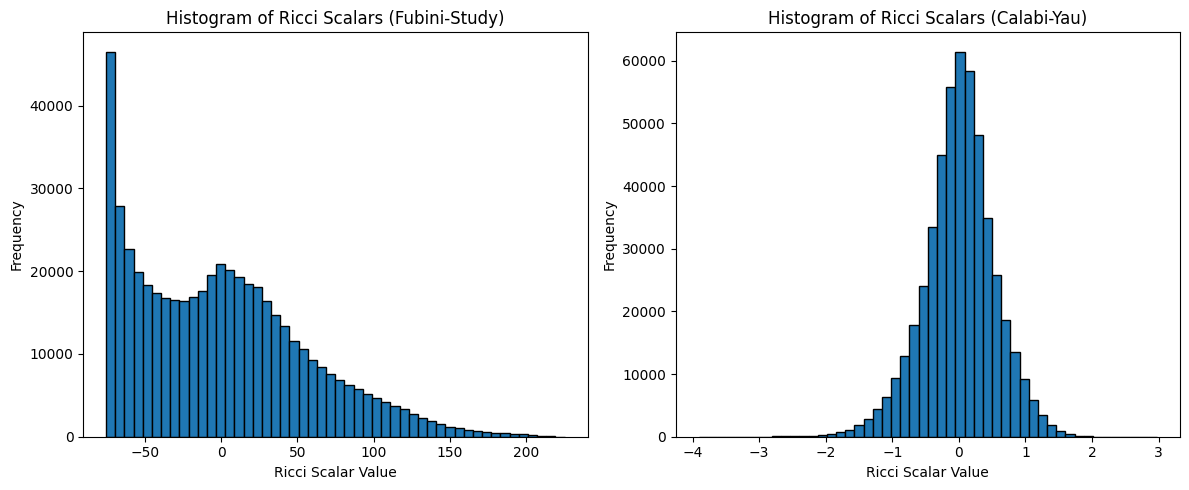

In [40]:
Riemann_tensors_FS_m_nb_rb_sbUP = Riemann_tensors_FS
Riemann_tensors_CY_m_nb_rb_sbUP = Riemann_tensors
metrics_FS = phimodel1.fubini_study_pb(realpoints)
metrics_CY = mets
inv_metrics_CY = tf.linalg.inv(metrics_CY)
inv_metrics_FS = tf.linalg.inv(metrics_FS)

Ricci_scalars_FS = 2*tf.einsum('xRm,xmNRN->x',inv_metrics_FS,Riemann_tensors_FS_m_nb_rb_sbUP)
Ricci_scalars_CY = 2*tf.einsum('xRm,xmNRN->x',inv_metrics_CY,Riemann_tensors_CY_m_nb_rb_sbUP)
print(tf.reduce_mean(Ricci_scalars_FS))
print(tf.reduce_mean(Ricci_scalars_CY))
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram of Ricci_scalars_FS
ax1.hist(Ricci_scalars_FS.numpy().flatten(), bins=50, edgecolor='black')
ax1.set_title('Histogram of Ricci Scalars (Fubini-Study)')
ax1.set_xlabel('Ricci Scalar Value')
ax1.set_ylabel('Frequency')

# Plot histogram of Ricci_scalars_CY
ax2.hist(Ricci_scalars_CY.numpy().flatten(), bins=50, edgecolor='black')
ax2.set_title('Histogram of Ricci Scalars (Calabi-Yau)')
ax2.set_xlabel('Ricci Scalar Value')
ax2.set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# # Print some statistics
# print("Fubini-Study Ricci Scalar Statistics:")
# print(f"Mean: {tf.reduce_mean(Ricci_scalars_FS):.4f}")
# print(f"Std Dev: {tf.math.reduce_std(Ricci_scalars_FS):.4f}")
# print(f"Min: {tf.reduce_min(Ricci_scalars_FS):.4f}")
# print(f"Max: {tf.reduce_max(Ricci_scalars_FS):.4f}")

# print("\nCalabi-Yau Ricci Scalar Statistics:")
# print(f"Mean: {tf.reduce_mean(Ricci_scalars_CY):.4f}")
# print(f"Std Dev: {tf.math.reduce_std(Ricci_scalars_CY):.4f}")
# print(f"Min: {tf.reduce_min(Ricci_scalars_CY):.4f}")
# print(f"Max: {tf.reduce_max(Ricci_scalars_CY):.4f}")



In [ ]:
# data=np.load('dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) + '/datasetold.npz')

# np.savez_compressed(os.path.join(dirnameAlpha, 'dataset'),
#                         X_train=data['X_train'],
#                         y_train=data['y_train'],
#                         train_pullbacks=data['train_pullbacks'],
#                         inv_mets_train=data['inv_mets_train'],
#                         sources_train=sources2_train,
#                         X_val=data['X_val'],
#                         y_val=data['y_val'],
#                         val_pullbacks=data['val_pullbacks'],
#                         inv_mets_val=data['inv_mets_val'],
#                         sources_val=sources2_val
#                         )

In [ ]:
# sources2_train = modify_sources[:t_i]
# sources2_val = modify_sources[t_i:]

In [ ]:
# flat_weights=weights[:,0]*omega[:,0]**(-1)*1/6
# cy_weights=absdets*flat_weights
# # sources = tf.concat((data['sources_train'],data['sources_val']),axis=0)
# vol_actual = tf.reduce_mean(cy_weights)
# print(vol_actual)
# modify_sources = sources - (-200/(6*vol_actual)) + (-200/vol_actual)
# integral_of_sources = tf.reduce_mean(cy_weights*sources,axis=0)
# integral_of_abs_sources = tf.reduce_mean(cy_weights*tf.math.abs(sources),axis=0)
# integral_of_modify_sources = tf.reduce_mean(cy_weights*modify_sources,axis=0)
# integral_of_abs_modify_sources = tf.reduce_mean(cy_weights*tf.math.abs(modify_sources),axis=0)
# print(integral_of_sources)
# print(integral_of_abs_sources)
# print(integral_of_modify_sources)
# print(integral_of_abs_modify_sources)
# t_i = int((1-0.1)*len(ys))
# datadict = dict(data)
# datadict['sources_train'] = modify_sources[:t_i]
# datadict['sources_val'] = modify_sources[t_i:] 
# sources2_train = modify_sources[:t_i]
# sources2_val = modify_sources[t_i:]


#save datadict
# dirnameAlpha = "dataAlphaP/QuinticAlpha_pg_with_1e-14"
# np.savez_compressed(os.path.join(dirnameAlpha, 'dataset2'),datadict)
# data['sources_train = ']

In [122]:
# generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel1,-200.,force_generate=False,seed_set=0,batch_size=128)
alphaprime=1
euler_char=-200
depthAlpha=4
#widthAlpha=128
widthAlpha=64
nEpochsAlpha=60
#nEpochsAlpha=2
lRate=0.01
lRate=0.001

train_alpha=True
if train_alpha:
    AlphaModel1,training_historyAlpha=train_and_save_nn_Alpha(free_coefficient,phimodel1,euler_char,alphaprime,depthAlpha,widthAlpha,nEpochsAlpha,bSizes=[64,50000],stddev=0.05,lRate=lRate,use_zero_network=False,alpha=[1.,1.],load_network=False)
else:
    AlphaModel1,training_historyAlpha=load_nn_Alpha(free_coefficient,phimodel1,euler_char,alphaprime,depthAlpha,widthAlpha,nEpochsAlpha,[64,50000],set_weights_to_zero=True)

name: alphamodel_for_60_64_4x64
network shape: [25, 64, 64, 64, 64, 1]
trying iteration of training 0

Epoch  1/60
Epoch 1/60
7025/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - laplacian_loss: 358294.0625 - loss: 358294.0625 - transition_loss: 3.8420e-06 - Laplacian measure val: 15.1491
 - Transition measure val: 2.5745e-06
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - laplacian_loss: 357886.5000 - loss: 357886.5000 - transition_loss: 3.8404e-06 - laplacian_val: 15.1491 - transition_val: 2.5745e-06
Epoch 2/60
7025/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - laplacian_loss: 15.5834 - loss: 15.5834 - transition_loss: 2.1778e-06 - Laplacian measure val: 16.9480
 - Transition measure val: 1.9861e-06
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - laplacian_loss: 15.5851 - loss: 15.5851 - transition_loss: 2.1769e-06 - laplacian_val: 16.9480 - transition_val: 1.9861e-06
Epoch 3/60
7028/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - laplacian_loss: 14.3056 - loss: 14.3056 - transition_loss: 1.9208e-06 - Laplaci

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



7024/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - laplacian_loss: 11.0381 - loss: 11.0381 - transition_loss: 9.8192e-07 - Laplacian measure val: 11.1023
 - Transition measure val: 9.7097e-07
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - laplacian_loss: 11.0369 - loss: 11.0369 - transition_loss: 9.8207e-07 - laplacian_val: 11.1023 - transition_val: 9.7097e-07
Epoch 34/60
7023/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - laplacian_loss: 10.9899 - loss: 10.9899 - transition_loss: 9.6607e-07 - Laplacian measure val: 10.5071
 - Transition measure val: 9.5101e-07
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - laplacian_loss: 10.9908 - loss: 10.9908 - transition_loss: 9.6611e-07 - laplacian_val: 10.5071 - transition_val: 9.5101e-07
Epoch 35/60
7024/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - laplacian_loss: 11.0243 - loss: 11.0243 - transition_loss: 9.5002e-07 - Laplacian measure val: 11.2112
 - Transition measure val: 9.3052e-07
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - laplacian_loss: 11.0236 - loss: 

: 

In [41]:
alphaprime=1
euler_char=-200
depthAlpha=4
#widthAlpha=128
widthAlpha=64
nEpochsAlpha=60
#nEpochsAlpha=2
lRate=0.01
lRate=0.001
AlphaModel1,training_historyAlpha1=load_nn_Alpha(free_coefficient,phimodel1,euler_char,alphaprime,depthAlpha,widthAlpha,nEpochsAlpha,[64,50000],set_weights_to_zero=False)

name: alphamodel_for_60_64_4x64
network shape: [25, 64, 64, 64, 64, 1]
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - laplacian_loss: 197.3703 - loss: 197.3703 - transition_loss: 0.0000e+00
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - laplacian_loss: 10.7001 - loss: 10.7001 - transition_loss: 1.0607e-06
zero network validation loss: 
{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=371.64453>, 'laplacian_loss': <tf.Tensor: shape=(), dtype=float32, numpy=371.64453>, 'transition_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
validation loss for trained network: 
{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=16.137903>, 'laplacian_loss': <tf.Tensor: shape=(), dtype=float32, numpy=16.137903>, 'transition_loss': <tf.Tensor: shape=(), dtype=float32, numpy=9.685755e-07>}
ratio of trained to zero: {'loss ratio': <tf.Tensor: shape=(), dtype=float32, numpy=0.043422952>, 'laplacian_loss ratio': <tf.Tensor: shape=(), dtype=float32, numpy=0.043422952>, 'transition_loss ratio': <tf.T

In [ ]:
# #reimport custom_networks
# importlib.reload(sys.modules['custom_networks'])
# from custom_networks import *
# #reimport laplacian_funcs
# importlib.reload(sys.modules['laplacian_funcs'])
# from laplacian_funcs import *

In [43]:
data=np.load('dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) + '/dataset.npz')
#(self,kphi,linebundleindices,ambient_env_var,n_projective,kmoduli)
n_0=0
n_p= 500000*9//10#500000*9//10
ptdata=tf.cast(data['X_train'],real_dtype)[n_0:n_p]
#cptdata=point_vec_to_complex(ptdata)
#cptdata2=cptdata/cptdata[:,0:1]
flat_measure_weights=tf.cast(((data['y_train'][:,0]/(data['y_train'][:,1]))*(1/(6)))[n_0:n_p],real_dtype)
pullbacks=AlphaModel1.pullbacks(ptdata)#[n_0:n_p]
kphi = np.array([3])
#get_sections_cpts_func=get_degree_kphiandMmonomials_general(kphi,[0],ambientTQ,len(ambientTQ),kmoduliTQ)
# get_sections_cpts_func(cptdata)


In [44]:

#tf.function this, but for fixed arguments 0,2 and tensor arguments 1,3,4

def compute_matrices_for_pts(rpoints,metric,correctedmetric,flat_measure_weights,pullbacks,get_sections_cpts_func):
    get_sections_rpts_func= lambda x: get_sections_cpts_func(point_vec_to_complex(x))
    metrics = metric(rpoints)
    #assume alphaprime = 1, should be asserted elsewhere in the code?
    #correctedmetrics = correctedmetric(rpoints)
    deltawithalphaprime1_abbar=correctedmetric.call_only_shift(rpoints)#correctedmetrics-metrics
    inversemetrics=tf.linalg.inv(metrics)
    dets = tf.linalg.det(metrics)
    #k_phi=get_sections_rpts_func(cpoints)
    sigmas=get_sections_rpts_func(rpoints)
    sigmasbar=tf.math.conj(sigmas)

    djsigma=extder_j_for_sigma(rpoints,get_sections_rpts_func)
    djbarsigma=extder_jbar_for_sigma(rpoints,get_sections_rpts_func)
    dasigma = tf.einsum('xai,xCi->xCa',pullbacks,djsigma)
    dbbarsigma = tf.einsum('xbj,xCj->xCb',tf.math.conj(pullbacks),djbarsigma)
    #b is barred, a is unbarred
    dbarfbar_df = tf.einsum('xba,xCb,xDa->xCD',inversemetrics,tf.math.conj(dasigma),dasigma)
    dfbar_dbarf = tf.einsum('xba,xCa,xDb->xCD',inversemetrics,tf.math.conj(dbbarsigma),dbbarsigma)
    lambda_trace_delta = lambda x: tf.einsum('xba,xab->x',tf.linalg.inv(metric(x)),correctedmetric.call_only_shift(x))
    djtrdelta=extder_j_for_sigma(rpoints,lambda_trace_delta)
    datrdelta=tf.einsum('xai,xi->xa',pullbacks,djtrdelta)
    dbbartrdelta = tf.math.conj(datrdelta)# as delta is real
    #trace_delta = tf.einsum('xba,xab->x',inversemetrics,deltawithalphaprime1_abbar) 
    
    mdelta_ginv_two_up_indices_bbar_a = tf.einsum('xBa,xDc,xaD->xBc',inversemetrics,inversemetrics,-1*deltawithalphaprime1_abbar)
    #print(mdelta_ginv_two_up_indices_bbar_a)
    mDELTAdbarfbar_df = tf.einsum('xba,xCb,xDa->xCD',mdelta_ginv_two_up_indices_bbar_a,tf.math.conj(dasigma),dasigma)
    mDELTAdfbar_dbarf = tf.einsum('xba,xCa,xDb->xCD',mdelta_ginv_two_up_indices_bbar_a,tf.math.conj(dbbarsigma),dbbarsigma)

    mDELTAfbar_dbarD_df = -1*tf.einsum('xba,xC,xb,xDa->xCD',inversemetrics,sigmasbar,dbbartrdelta,dasigma)
    mDELTAfbar_dD_dbarf = -1*tf.einsum('xba,xC,xa,xDb->xCD',inversemetrics,sigmasbar,datrdelta,dbbarsigma)
    # print(mDELTAdbarfbar_df)
    # print(mDELTAdfbar_dbarf)
    # print(mDELTAfbar_dbarD_df)
    # print(mDELTAfbar_dD_dbarf)
    
    #factor of 2 form the laplacian!
    integrand_CD = tf.einsum('xCD,x->xCD',2*(dbarfbar_df + dfbar_dbarf),dets*tf.cast(flat_measure_weights,complex_dtype))
    mDELTAintegrand_CD_1 = tf.einsum('xCD,x->xCD',2*(mDELTAdbarfbar_df + mDELTAdfbar_dbarf),dets*tf.cast(flat_measure_weights,complex_dtype))
    mDELTAintegrand_CD_2 = tf.einsum('xCD,x->xCD',2*(mDELTAfbar_dbarD_df + mDELTAfbar_dD_dbarf),dets*tf.cast(flat_measure_weights,complex_dtype))
    integrand_mean=tf.reduce_mean(integrand_CD,axis=0)
    DELTAintegrand_mean=tf.reduce_mean(mDELTAintegrand_CD_1+mDELTAintegrand_CD_2,axis=0)
    print("vol: " + str(tf.reduce_mean(dets*tf.cast(flat_measure_weights,complex_dtype))))
    return integrand_mean,DELTAintegrand_mean
    
get_sections_cpts_func=get_degree_kphiandMmonomials_general(kphi,kphi*0,ambientTQ,len(ambientTQ),kmoduliTQ)
#mats=compute_matrices_for_pts(kphi,ptdata,AlphaModel1,flat_measure_weights,pullbacks,get_sections_cpts_func)




In [45]:
def compute_normalising_matrices_for_pts(rpoints,metric,flat_measure_weights,get_sections_cpts_func):
    get_sections_rpts_func= lambda x: get_sections_cpts_func(point_vec_to_complex(x))
    metrics = metric(rpoints)
    dets = tf.linalg.det(metrics)
    sectionsB    = get_sections_rpts_func(rpoints)
    sectionsConjA   = tf.math.conj(sectionsB)

    #k_phi=get_sections_rpts_func(cpoints)
    integrand_CD = tf.einsum('xA,xB,x->AB',sectionsConjA,sectionsB,dets*tf.cast(flat_measure_weights,complex_dtype))
    integrand_CD=integrand_CD/tf.cast(rpoints.shape[0],complex_dtype)
    print("vol: " + str(tf.reduce_mean(dets*tf.cast(flat_measure_weights,complex_dtype))))
    return integrand_CD

In [23]:
#test runtime!
benchmark_times=[]
try_batches=[100,200,300,400,500]
for batch_size in try_batches:
    #batch_size=400
    print("batch_size: " + str(batch_size))
    metric_using=phimodel1
    correctedmetric=AlphaModel1
    #check that alphaprime is set to 1
    assert np.abs(correctedmetric.alphaprime-1)<1e-8

    #create compiled versions
    @tf.function
    def compute_matrices_for_pts_fixed(rpoints, flat_measure_weights, pullbacks):
        #kphi = tf.constant([1])  # Fixed argument
        return compute_matrices_for_pts(rpoints, metric_using,correctedmetric, flat_measure_weights, pullbacks,get_sections_cpts_func)

    # Get the concrete function
    concrete_func = compute_matrices_for_pts_fixed.get_concrete_function(
        tf.TensorSpec(shape=(batch_size,2*metric_using.ncoords), dtype=real_dtype),  # rpoints
        tf.TensorSpec(shape=(batch_size), dtype=real_dtype),  # flat_measure_weights
        tf.TensorSpec(shape=(batch_size, metric_using.nfold,metric_using.ncoords), dtype=complex_dtype)  # pullbacks
    )

    dataset = tf.data.Dataset.from_tensor_slices((ptdata, flat_measure_weights, pullbacks))
    batched_dataset = dataset.batch(batch_size)
    import time
    start = time.time()
    for batch in batched_dataset.take(2):
        batch_rpoints, batch_flat_measure_weights, batch_pullbacks = batch
        batch_result,delta_batch_result = compute_matrices_for_pts_fixed(batch_rpoints, batch_flat_measure_weights, batch_pullbacks)
        #oresults.append(batch_result)
        benchmark_time=(time.time()-start)*100/batch_size
        print('done, timing: ' + str(benchmark_time))
        start=time.time()
    #outside the loop so the compiled benchmark time is used
    benchmark_times.append(benchmark_time)

# print("\n\n concrete" )
# import time
# start = time.time()
# for batch in batched_dataset.take(4):
#     batch_rpoints, batch_flat_measure_weights, batch_pullbacks = batch
#     batch_result,delta_batch_result = concrete_func(batch_rpoints, batch_flat_measure_weights, batch_pullbacks)
#     #oresults.append(batch_result)
#     print('done, timing: ' + str(time.time()-start))
#     start=time.time()

#batch size 100
#done, timing: 38.546314001083374
#done, timing: 4.598233461380005

#batch size 400
#done, timing: 162.41296458244324
#done, timing: 14.256128311157227

batch_size: 100


: 

In [46]:
data = np.load('dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) + '/dataset.npz')
data['sources_val']
zeta_of_3=1.2020569031595942853997381
data_scaled =1/4 *zeta_of_3*data['sources_val']*(1/np.pi**3)
print(data_scaled)

[-1.4993079 -2.0843098 -2.1463535 ... -2.0950775 -2.016463  -1.8360475]


In [ ]:
import matplotlib.pyplot as plt

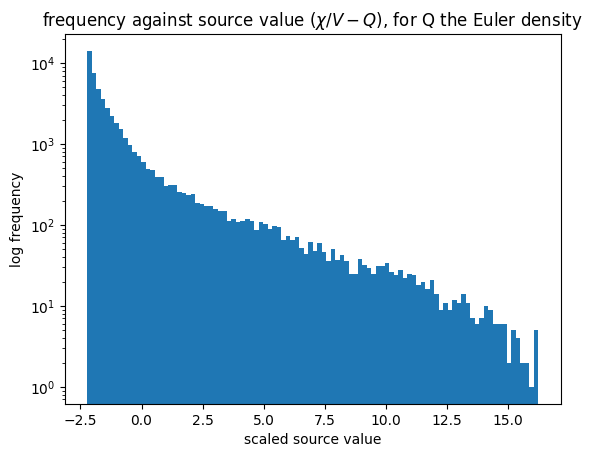

In [47]:
plt.hist(data_scaled,bins=100,log=True)
#add itle and axes
plt.title("frequency against source value ($\chi/V-Q$), for Q the Euler density")
plt.xlabel("scaled source value")
plt.ylabel("log frequency")
plt.show()

In [89]:
#best_batch_size=try_batches[np.argmin(np.array(benchmark_times))]
best_batch_size=500
batch_size=best_batch_size#400
print("using batch_size: " + str(batch_size))
AlphaModel1.alphaprime=0.03
metric_using=phimodel1
correctedmetric=AlphaModel1
#check that alphaprime is set to 1
assert np.abs(correctedmetric.alphaprime-0.03)<1e-8

#create compiled versions
@tf.function
def compute_matrices_for_pts_fixed(rpoints, flat_measure_weights, pullbacks):
    #kphi = tf.constant([1])  # Fixed argument
    return compute_matrices_for_pts(rpoints, metric_using,correctedmetric, flat_measure_weights, pullbacks,get_sections_cpts_func)

# Get the concrete function
concrete_func = compute_matrices_for_pts_fixed.get_concrete_function(
    tf.TensorSpec(shape=(batch_size,2*metric_using.ncoords), dtype=real_dtype),  # rpoints
    tf.TensorSpec(shape=(batch_size), dtype=real_dtype),  # flat_measure_weights
    tf.TensorSpec(shape=(batch_size, metric_using.nfold,metric_using.ncoords), dtype=complex_dtype)  # pullbacks
)

@tf.function
def compute_normalising_matrices_for_pts_fixed(rpoints, flat_measure_weights):
    #kphi = tf.constant([1])  # Fixed argument
    return compute_normalising_matrices_for_pts(rpoints, metric_using, flat_measure_weights,get_sections_cpts_func)

# Get the concrete function for the normalising matrix
concrete_func_normalising = compute_normalising_matrices_for_pts_fixed.get_concrete_function(
    tf.TensorSpec(shape=(batch_size,2*metric_using.ncoords), dtype=real_dtype),  # rpoints
    tf.TensorSpec(shape=(batch_size), dtype=real_dtype),  # flat_measure_weights
)

#compute_matrices_for_pts_fixed(ptdata, flat_measure_weights, pullbacks)

using batch_size: 500
vol: Tensor("Mean_2:0", shape=(), dtype=complex64)
vol: Tensor("Mean:0", shape=(), dtype=complex64)


In [61]:
# Assuming the concrete_func is defined as in the previous example

# Create a dataset from your large number of points
dataset = tf.data.Dataset.from_tensor_slices((ptdata, flat_measure_weights, pullbacks))#.take(batch_size*20)
# Adjust based on your memory constraints and performance needs
assert (len(ptdata)/batch_size)%1==0


# Batch the dataset
num_points = len(ptdata)
batched_dataset = dataset.batch(batch_size)
number_of_batches = int(tf.math.ceil(len(dataset)/batch_size))
save_every_n_batches = max(int(number_of_batches//20),1)
saved_batch_indices = list(range(0,number_of_batches,save_every_n_batches))
saved_point_numbers=save_every_n_batches*batch_size*np.array(saved_batch_indices)

# Process batches
size_of_matrix = get_sections_cpts_func.n_secs
results = np.zeros((size_of_matrix, size_of_matrix), np.float64)
results_saved=[]
DELTAresults =  np.zeros((size_of_matrix, size_of_matrix), np.float32)
DELTAresults_saved=[]
i=0
for batch in batched_dataset:
    batch_rpoints, batch_flat_measure_weights, batch_pullbacks = batch
    batch_result,DELTAbatch_result = concrete_func(batch_rpoints, batch_flat_measure_weights, batch_pullbacks)
    results += batch_result
    DELTAresults+=DELTAbatch_result
    #if batch# % save_every_n_batches == 0, save results
    if i % save_every_n_batches == 0:
        print('batch: ' + str(i) + " of " + str(number_of_batches))
        results_saved.append(results/float((i+1)))#remember to average over batches
        DELTAresults_saved.append(DELTAresults/float((i+1)))

    i+=1



# Batch the dataset
num_points = len(ptdata)
batched_dataset = dataset.batch(batch_size)
number_of_batches = int(tf.math.ceil(len(dataset)/batch_size))
save_every_n_batches = max(int(number_of_batches//20),1)
saved_batch_indices = list(range(0,number_of_batches,save_every_n_batches))
saved_point_numbers=save_every_n_batches*batch_size*np.array(saved_batch_indices)

# Process batches
size_of_matrix = get_sections_cpts_func.n_secs
#average over the dataset to do the integration - note that the average has already been done in each batch.
matrix_laplacian_requires_mean = np.array(results)/len(batched_dataset)
matrix_DELTAlaplacian_requires_mean = np.array(DELTAresults)/len(batched_dataset)

#convert our lists to arrays
SAVED_matrix_laplacian_requires_mean = np.array(results_saved)
SAVED_matrix_DELTAlaplacian_requires_mean = np.array(DELTAresults_saved)

print(f"Processed {len(dataset)} points. Shape of final result: {SAVED_matrix_laplacian_requires_mean.shape}")

#results_norm = []
results_norm = np.zeros((size_of_matrix, size_of_matrix), np.float64)
results_norm_saved=[]
i=0
for batch in batched_dataset:
    batch_rpoints, batch_flat_measure_weights,_ = batch
    batch_result_norm = concrete_func_normalising(batch_rpoints, batch_flat_measure_weights)
    results_norm+=(batch_result_norm)
    if i % save_every_n_batches == 0:
        print('batch: ' + str(i))
        results_norm_saved.append(results_norm/float((i+1)))
    i+=1

matrix_normalising_requires_mean = np.array(results_norm)/len(batched_dataset)
SAVED_matrix_normalising_requires_mean = np.array(results_norm_saved)

print(f"Processed {len(dataset)} points. Shape of saved final result: {SAVED_matrix_normalising_requires_mean.shape}")
#save all the various matrices
dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 
np.savez_compressed(os.path.join(dirnameAlpha, 'laplacian_matrices' + str(kphi) + 'k'+str(int(time.time()))),
                        matrix_laplacian_requires_mean=matrix_laplacian_requires_mean,
                        matrix_DELTAlaplacian_requires_mean=matrix_DELTAlaplacian_requires_mean,
                        SAVED_matrix_laplacian_requires_mean=SAVED_matrix_laplacian_requires_mean,
                        SAVED_matrix_DELTAlaplacian_requires_mean=SAVED_matrix_DELTAlaplacian_requires_mean,
                        matrix_normalising_requires_mean=matrix_normalising_requires_mean,
                        SAVED_matrix_normalising_requires_mean=SAVED_matrix_normalising_requires_mean,
                        saved_batch_indices=saved_batch_indices,
                        saved_point_numbers=saved_point_numbers
                        )

batch: 0 of 900
batch: 45 of 900
batch: 90 of 900
batch: 135 of 900
batch: 180 of 900
batch: 225 of 900
batch: 270 of 900
batch: 315 of 900
batch: 360 of 900
batch: 405 of 900
batch: 450 of 900
batch: 495 of 900
batch: 540 of 900


: 

In [87]:
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3, 5), dtype=tf.complex64, name=None))>

In [91]:

# Batch the dataset
num_points = len(ptdata)
batched_dataset = dataset.batch(batch_size)
number_of_batches = int(tf.math.ceil(len(dataset)/batch_size))
save_every_n_batches = max(int(number_of_batches//20),1)
saved_batch_indices = list(range(0,number_of_batches,save_every_n_batches))
saved_point_numbers=save_every_n_batches*batch_size*np.array(saved_batch_indices)
print("len of batched dataset: " + str(len(batched_dataset)))
#print("shape of first element of batched dataset: " + str(batched_dataset[0].shape))
# Process batches
size_of_matrix = get_sections_cpts_func.n_secs

#average over the dataset to do the integration - note that the average has already been done in each batch.
matrix_laplacian_requires_mean = np.array(results)/len(batched_dataset)
matrix_DELTAlaplacian_requires_mean = np.array(DELTAresults)/len(batched_dataset)

#convert our lists to arrays
SAVED_matrix_laplacian_requires_mean = np.array(results_saved)
SAVED_matrix_DELTAlaplacian_requires_mean = np.array(DELTAresults_saved)

print(f"Processed {len(dataset)} points. Shape of final result: {SAVED_matrix_laplacian_requires_mean.shape}")

#results_norm = []
results_norm = np.zeros((size_of_matrix, size_of_matrix), np.float64)
results_norm_saved=[]
i=0
for batch in batched_dataset:
    batch_rpoints, batch_flat_measure_weights,_ = batch
    batch_result_norm = concrete_func_normalising(batch_rpoints, batch_flat_measure_weights)
    results_norm+=(batch_result_norm)
    if i % save_every_n_batches == 0:
        print('batch: ' + str(i))
        results_norm_saved.append(results_norm/float((i+1)))
    i+=1

matrix_normalising_requires_mean = np.array(results_norm)/len(batched_dataset)
SAVED_matrix_normalising_requires_mean = np.array(results_norm_saved)

print(f"Processed {len(dataset)} points. Shape of saved final result: {SAVED_matrix_normalising_requires_mean.shape}")
#save all the various matrices
dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 
np.savez_compressed(os.path.join(dirnameAlpha, 'laplacian_matrices_fixed_' + str(kphi) + 'k'+str(int(time.time()))),
                        matrix_laplacian_requires_mean=matrix_laplacian_requires_mean,
                        matrix_DELTAlaplacian_requires_mean=matrix_DELTAlaplacian_requires_mean,
                        SAVED_matrix_laplacian_requires_mean=SAVED_matrix_laplacian_requires_mean,
                        SAVED_matrix_DELTAlaplacian_requires_mean=SAVED_matrix_DELTAlaplacian_requires_mean,
                        matrix_normalising_requires_mean=matrix_normalising_requires_mean,
                        SAVED_matrix_normalising_requires_mean=SAVED_matrix_normalising_requires_mean,
                        saved_batch_indices=saved_batch_indices,
                        saved_point_numbers=saved_point_numbers
                        )

len of batched dataset: 900
Processed 450000 points. Shape of final result: (20, 1225, 1225)
batch: 0
batch: 45
batch: 90
batch: 135
batch: 180
batch: 225
batch: 270
batch: 315
batch: 360
batch: 405
batch: 450
batch: 495
batch: 540
batch: 585
batch: 630
batch: 675
batch: 720
batch: 765
batch: 810
batch: 855
Processed 450000 points. Shape of saved final result: (20, 1225, 1225)


In [82]:
# np.savez_compressed(os.path.join(dirnameAlpha, 'laplacian_matricesTEMP' + str(kphi) + 'k'+str(int(time.time()))),
#                         matrix_laplacian_requires_mean=matrix_laplacian_requires_mean,
#                         matrix_DELTAlaplacian_requires_mean=matrix_DELTAlaplacian_requires_mean,
#                         SAVED_matrix_laplacian_requires_mean=SAVED_matrix_laplacian_requires_mean,
#                         SAVED_matrix_DELTAlaplacian_requires_mean=SAVED_matrix_DELTAlaplacian_requires_mean,
#                         #matrix_normalising_requires_mean=matrix_normalising_requires_mean,
#                         #SAVED_matrix_normalising_requires_mean=SAVED_matrix_normalising_requires_mean,
#                         saved_batch_indices=saved_batch_indices,
#                         saved_point_numbers=saved_point_numbers
#                         )

In [64]:

# dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 
# time = 1728952849.9753003
# loaded_data = np.load(os.path.join(dirnameAlpha, 'laplacian_matrices' + str(kphi) + 'k'+str(time) + '.npz'))

In [67]:
# loaded_data.keys()
# loaded_data['SAVED_matrix_DELTAlaplacian_requires_mean'][0]

In [70]:
# !ls dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices*

 dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices1723659522.3979912.npz
 dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices1723675547.1185184.npz
 dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices1723693920.555222.npz
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[1]k1723714970.5424657.npz'
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[1]k1723725621.1390874.npz'
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[1]k1723732384.146569.npz'
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[1]k1723733320.7432308.npz'
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[2]k1723716465.7617283.npz'
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[2]k1723717717.2117028.npz'
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[2]k1723718968.338281.npz'
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[2]k1723720241.5144975.npz'
'dataAlphaP/QuinticAlpha_pg_with_1e-14/laplacian_matrices[2]k1723734805.8548298.npz

In [92]:
import scipy
#take eigs of final_result, but build it up step_by_ste


def sorted_eigensystem(matrix,matrix_norm):
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = scipy.linalg.eig(matrix,matrix_norm)

    # Create a list of tuples containing (eigenvalue, eigenvector)
    eig_pairs = list(zip(eigenvalues, eigenvectors.T))

    # Sort the pairs based on the magnitude of the real part of the eigenvalues
    sorted_pairs = sorted(eig_pairs, key=lambda x: abs(x[0].real), reverse=False)

    # Separate the sorted eigenvalues and eigenvectors
    sorted_eigenvalues, sorted_eigenvectors = zip(*sorted_pairs)

    # Convert the sorted eigenvectors back to a numpy array
    sorted_eigenvectors = np.array(sorted_eigenvectors)

    return sorted_eigenvalues, sorted_eigenvectors

#log distribute over 1 to 100000
number_approx=6


# numbers_to_take= np.unique((batch_size*np.round(np.logspace(np.log10(10000),np.log10(len(ptdata)),number_approx)/batch_size)).astype('int'))[0:]
# indices_to_take=tf.cast(numbers_to_take/batch_size,tf.int32).numpy()
# indices_to_take[0]
indices_to_take=np.unique((np.round(np.logspace(np.log10(2),np.log10(len(saved_batch_indices)),number_approx))).astype('int'))[0:]-1
numbers_to_take= save_every_n_batches*batch_size*indices_to_take
print(indices_to_take)
print(numbers_to_take)

eig_shifts_without_alphaprime=[]
eigvals_all=[]
for i in indices_to_take:
    matrix=SAVED_matrix_laplacian_requires_mean[i]#tf.reduce_mean(np.array(results)[0:i],axis=0)
    matrix_norm=SAVED_matrix_normalising_requires_mean[i]#tf.reduce_mean(np.array(results_norm)[0:i],axis=0)
    delta_matrix=SAVED_matrix_DELTAlaplacian_requires_mean[i]
    #eigvals=tf.math.real(scipy.linalg.eigvals(matrix,matrix_norm))
    #eigvals_all.append(np.sort(eigvals))
    eigvals,eigvecs=sorted_eigensystem(matrix,matrix_norm)
    eigvals=tf.math.real(eigvals)
    eigvals_all.append(eigvals)
    expectation_of_gamma=tf.einsum('xi,xj,ij->x',tf.math.conj(eigvecs),eigvecs,delta_matrix)
    divided_by_state = tf.einsum('xi,xj,ij->x',tf.math.conj(eigvecs),eigvecs,matrix_norm) 
    eig_shifts=expectation_of_gamma/divided_by_state
    eig_shifts_without_alphaprime.append(eig_shifts)

    #round and print to 2dp
    #eigvals_rounded=np.round(eigvals,2)
    #print(tf.math.real(eigvals_rounded))
eigvals_all=np.array(eigvals_all)
eig_shifts_without_alphaprime=np.array(eig_shifts_without_alphaprime)

[ 1  2  4  7 12 19]
[ 22500  45000  90000 157500 270000 427500]


In [95]:
# SAVED_matrix_laplacian_requires_mean

In [93]:
# Search for NaNs in matrix and matrix_norm
print("NaNs in matrix:", tf.reduce_any(tf.math.is_nan(tf.math.imag( matrix))))
print("NaNs in matrix_norm:", tf.reduce_any(tf.math.is_nan(tf.math.imag(matrix_norm))))

# Optionally, you can also print the indices of NaN values if any are found

NaNs in matrix: tf.Tensor(False, shape=(), dtype=bool)
NaNs in matrix_norm: tf.Tensor(False, shape=(), dtype=bool)


In [96]:
#import kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import BisectingKMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
def curly_brace(x, y, width, height, ax):
    q = height / 4
    # ax.plot([x, x, x + width/2, x + width, x + width],
    #         [y - height/2, y + height/2, y + q, y + height/2, y - height/2],
    #         color='black')
    ax.plot([x, x+width, x + width/2, x + width, x],
            [y - height/2, y -q, y, y +q , y + height/2],
            color='black',linewidth=0.5)

def cluster_vector(vector, n_clusters=3, ax=None):
    X = np.array(vector).reshape(-1, 1)

    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    groups = []
    for i in range(n_clusters):
        group_values = X[cluster_labels == i]
        mean_value = np.mean(group_values)
        rangevals = np.max(group_values) - np.min(group_values)
        count = len(group_values)
        groups.append({
            'group_id': i + 1,
            'mean_value': mean_value,
            'count': count,
            'rangevals': rangevals,
            'indices': cluster_labels + 1
        })

    groups.sort(key=lambda x: x['mean_value'])

    if ax is not None:
        x_position = 427500
        for group in groups:
            y_position = group['mean_value']
            count = group['count']
            rangevals = group['rangevals']
            # Add curly brace
            curly_brace(x_position, y_position, 20000, rangevals, ax)
            # Add label
            ax.text(x_position + 25000, y_position, str(count),
                    va='center', ha='left', fontsize=10)

    print("Clustered groups:")
    for group in groups:
        print(f"Group {group['group_id']}: Mean = {group['mean_value']:.2f}, Count = {group['count']}")

    return groups

Clustered groups:
Group 3: Mean = 0.00, Count = 1
Group 2: Mean = 43.61, Count = 20
Group 6: Mean = 83.41, Count = 20
Group 4: Mean = 89.54, Count = 4
Group 1: Mean = 100.10, Count = 60
Group 5: Mean = 107.22, Count = 30
Clustered groups:
Group 3: Mean = 0.00, Count = 1
Group 2: Mean = 43.61, Count = 20
Group 6: Mean = 83.41, Count = 20
Group 4: Mean = 89.54, Count = 4
Group 1: Mean = 100.10, Count = 60
Group 5: Mean = 107.22, Count = 30


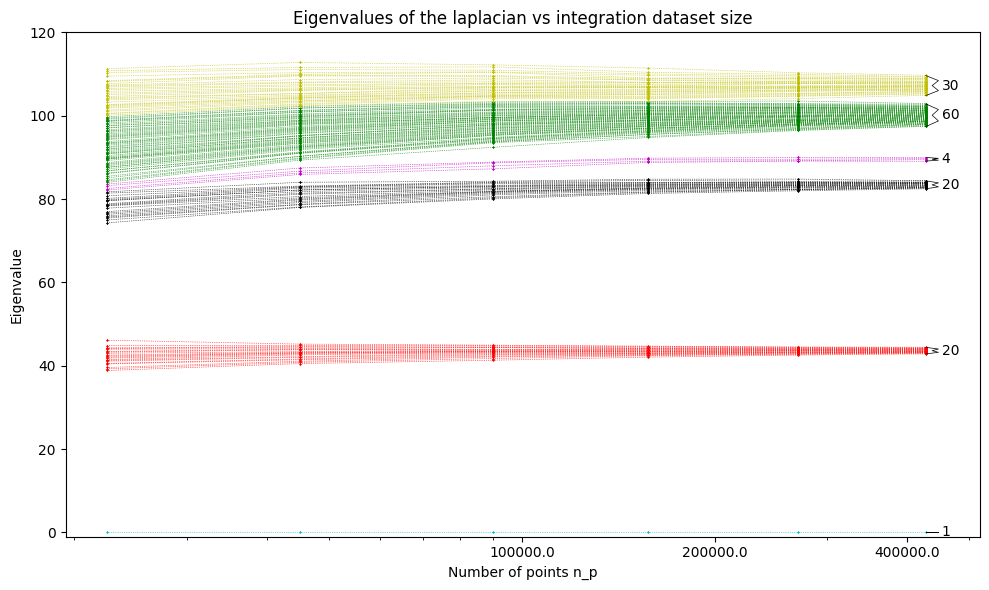

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap



fig, ax = plt.subplots(figsize=(10, 6))

eigvals_to_test=((eigvals_all[-1])[eigvals_all[-1]<120])
choose_number=len(eigvals_to_test)
n_bins = choose_number  # Number of color bins (1225 eigenvalues)
#result_clustering = cluster_vector(eigvals_to_test, min_samples=2, ax=ax,max_eps=30)

numbers_for_plotting=tf.repeat(tf.expand_dims(numbers_to_take,axis=-1),tf.shape(eigvals_all)[-1],axis=-1)
# Create a custom colormap from blue to red
colors = [(0, 0, 1), (1, 0, 0)]  # R -> G -> B
cmap = LinearSegmentedColormap.from_list('red_to_blue', colors, N=n_bins)

# Plot setup

result_clustering = cluster_vector(eigvals_to_test,n_clusters=6,ax=None)

color_list=['b','g','r','c','m','y','k','aquamarine','mediumseagreen','mediumblue']
# Plot each eigenvalue evolution with a different color
for i in range(choose_number):
    index=result_clustering[0]['indices'][i]
    #print(index)
    color= color_list[index]
    ax.plot(numbers_for_plotting[:,i], eigvals_all[:,i],
            marker='x', linestyle='dotted', color=color, linewidth=0.5, markersize=1)

# Set x-axis to log scale
ax.set_xscale('log')

# Set x-axis ticks
middle_pt = ((numbers_to_take[-1]-numbers_to_take[0])//(5000*2))*5000 + numbers_to_take[0]
middle_pt2 = ((numbers_to_take[-1]-numbers_to_take[0])//(5000*5))*5000 + numbers_to_take[0]
ticks = np.concatenate([np.array([0]),np.round(np.concatenate((numbers_to_take[[0,-1]], np.array([middle_pt, middle_pt2])))/100000)*100000])
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

# Set labels and title
ax.set_xlabel('Number of points n_p')
ax.set_ylabel('Eigenvalue')
ax.set_title('Eigenvalues of the laplacian vs integration dataset size')

# Set y-axis limit
ax.set_ylim(-1, 120)
#ax.set_xlim(420000, 430000)
#165=
result_clustering = cluster_vector(eigvals_to_test,n_clusters=6,ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
# testdata=ptdata[0:1000]
# pullbacks=phimodel1.pullbacks(testdata)
# invmetrics=tf.linalg.inv(phimodel1(testdata))

In [ ]:
# #reimport laplacia_funcs
# importlib.reload(sys.modules['laplacian_funcs'])
# from laplacian_funcs import *

In [34]:
# for i in range (0,100,10):
#     def test_function(x,training=True):
#         xc=point_vec_to_complex(x)
#         return tf.einsum('xa,a',get_sections_cpts_func(xc),eigvecs[i])

#     Hfunc=lambda x:  x[:,0]**0

#     apply_laplacian=-laplacianWithH(test_function,testdata,pullbacks,invmetrics,Hfunc)
#     data= 2*((apply_laplacian/test_function(testdata)))
#     mean = np.mean(data)
#     stddev=np.std(data)
#     print("mean " + str(mean) + " stddev " + str(stddev) + " actual " + str(eigvals[i]))

In [35]:
# for i in range (0,100,10):
#     def test_function(x,training=True):
#         xc=point_vec_to_complex(x)
#         return tf.einsum('xa,a',get_sections_cpts_func(xc),eigvecs[i])

#     Hfunc=lambda x:  x[:,0]**0

#     apply_laplacian=-laplacianWithH(test_function,testdata,pullbacks,invmetrics,Hfunc)
#     data= 2*((apply_laplacian/test_function(testdata)))
#     mean = np.mean(data)
#     stddev=np.std(data)
#     print("mean " + str(mean) + " stddev " + str(stddev) + " actual " + str(eigvals[i]))

In [36]:
# for i in range (0,100,10):
#     def test_function(x,training=True):
#         xc=point_vec_to_complex(x)
#         return tf.einsum('xa,a',get_sections_cpts_func(xc),eigvecs[i])

#     Hfunc=lambda x:  x[:,0]**0

#     apply_laplacian=-laplacianWithH(test_function,testdata,pullbacks,invmetrics,Hfunc)
#     data= 2*((apply_laplacian/test_function(testdata)))
#     mean = np.mean(data)
#     stddev=np.std(data)
#     print("mean " + str(mean) + " stddev " + str(stddev) + " actual " + str(eigvals[i]))

In [112]:
# # # Get the index of the largest absolute value
# # largest_index = tf.argmax(tf.abs(tf.math.imag(eig_shifts_without_alphaprime) / tf.math.real(eig_shifts_without_alphaprime)),axis=-1)

# # # Print the result
# print(f"Index of largest absolute value: {largest_index}")

Index of largest absolute value: [  0   0   0   0 308   0]


In [114]:
ticks

array([     0.,      0., 400000., 200000., 100000.])

In [136]:
numbers_for_plotting.shape
#relative_shifts.shape
#range(1,len(result_clustering[0]['indices']))

TensorShape([6, 1225])

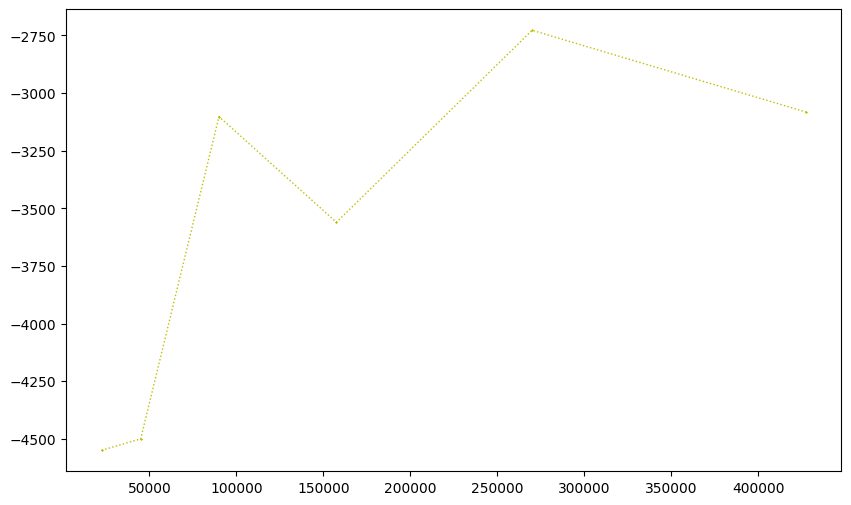

In [132]:

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(numbers_for_plotting[0:,2], relative_shifts[0:,2],
            marker='x', linestyle='dotted', color=color, linewidth=1, markersize=1)
plt.show()

In [141]:
ticks 

array([     0.,      0., 100000., 200000., 400000.])

In [157]:
np.round(eig_shifts_without_alphaprime[-1,0:100])*0.03**3

array([ 0.       +0.00e+00j, -0.817857 +0.00e+00j, -0.743121 -0.00e+00j,
       -0.645921 -2.70e-05j, -0.682749 +2.70e-05j, -0.788832 -1.62e-04j,
       -0.568512 -1.89e-04j, -0.568701 -0.00e+00j, -0.517266 -0.00e+00j,
       -0.439074 +0.00e+00j, -0.663363 +0.00e+00j, -0.442908 -0.00e+00j,
       -0.465264 +2.70e-05j, -0.457839 -2.70e-05j, -0.409941 -8.10e-05j,
       -0.401382 +0.00e+00j, -0.35802  +0.00e+00j, -0.50355  +2.70e-05j,
       -0.381591 +2.70e-05j, -0.39393  -0.00e+00j, -0.294462 -0.00e+00j,
        7.5465   +0.00e+00j,  7.584057 +2.70e-05j,  7.543287 -5.40e-05j,
        7.678422 -2.70e-05j,  7.721163 -5.40e-05j,  7.592994 +0.00e+00j,
        7.540911 -2.70e-05j,  7.551333 +0.00e+00j,  7.546365 +0.00e+00j,
        7.743276 +5.40e-05j,  7.708284 +2.70e-05j,  7.619751 +2.70e-05j,
        7.792146 +0.00e+00j,  7.600176 +8.10e-05j,  7.744626 +1.35e-04j,
        7.670916 +0.00e+00j,  7.587297 +2.70e-05j,  7.694892 +2.70e-05j,
        7.792389 -8.10e-05j,  7.776702 -5.40e-05j, 

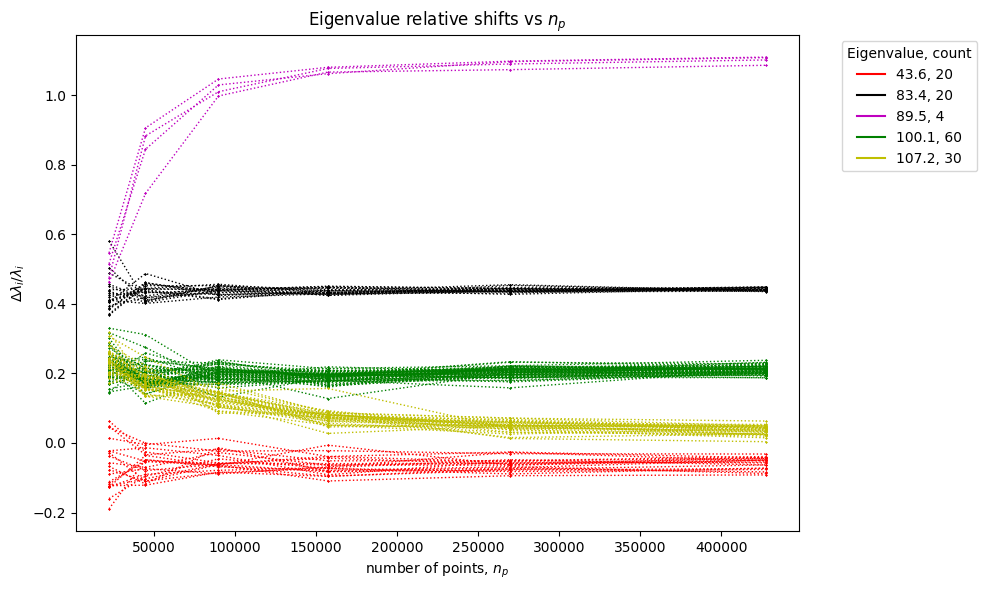

In [160]:
#You can create a separate plot showing the relative shifts (shift / original eigenvalue) to highlight which eigenvalues are most affected by the perturbation.
relative_shifts = tf.math.real(eig_shifts_without_alphaprime[:,:]*(0.03**(-3))*(1/(2*np.pi**2))**3/eigvals_all[:,:])
relative_shifts = tf.math.real(eig_shifts_without_alphaprime[:,:]*(1/(2*np.pi**2))**3/eigvals_all[:,:])

fig, ax = plt.subplots(figsize=(10, 6))
color_list=['b','g','r','c','m','y','k','aquamarine','mediumseagreen','mediumblue']

for i in range(1,len(result_clustering[0]['indices'])):#i.e omit the biggest
    #color according to the number from 1 to 10 (i.e. red, green, blue etc)
    index=result_clustering[0]['indices'][i]
    #print(index)
    color= color_list[index]
    mean_val=np.round(result_clustering[index-1]['mean_value'],2)
    #print(color_index)

    ax.plot(numbers_for_plotting[:,i], relative_shifts[:,i],
            marker='x', linestyle='dotted', color=color, linewidth=1, markersize=1)

#label colours as the mean value
for i in range(1,len(result_clustering)):
    #index=result_clustering[i]['mean_value']
    label_i=result_clustering[i]['group_id']
    ax.plot([], [], color=color_list[label_i], label=str(np.round(result_clustering[i]['mean_value'],1))+ ", "+str(np.round(result_clustering[i]['count'],2)))
#add legend
ax.legend(title='Eigenvalue, count', bbox_to_anchor=(1.05, 1), loc='upper left')

#ax.set_xscale('log')
#ax.set_xticks(ticks)
#ax.set_xticklabels(ticks)
ax.set_xlabel('number of points, $n_p$')
ax.set_ylabel('$\Delta\lambda_i/\lambda_i$')
ax.set_title('Eigenvalue relative shifts vs $n_p$')

plt.tight_layout()
plt.show()

In [164]:
relative_shifts

<tf.Tensor: shape=(6, 1225), dtype=float32, numpy=
array([[ 7.4913277e-04, -4.3338380e+00, -4.8224363e+00, ...,
         3.3668924e+02,  3.1431412e+02,  3.2389401e+02],
       [ 6.1126356e-04, -2.1769633e+00, -4.9584684e+00, ...,
         3.2486261e+02,  3.0810657e+02,  3.2482251e+02],
       [-3.6044180e-04, -2.6157498e+00, -3.4954491e+00, ...,
         3.1785690e+02,  3.1528046e+02,  3.1988089e+02],
       [ 6.1461474e-06, -4.5986586e+00, -4.0759716e+00, ...,
         3.1212778e+02,  3.1146298e+02,  3.1609979e+02],
       [ 2.5114326e-05, -4.0074940e+00, -3.1489766e+00, ...,
         3.1184131e+02,  3.0972977e+02,  3.1298782e+02],
       [ 4.2794047e-05, -3.9383786e+00, -3.5784998e+00, ...,
         3.0940884e+02,  3.1240384e+02,  3.1242575e+02]], dtype=float32)>

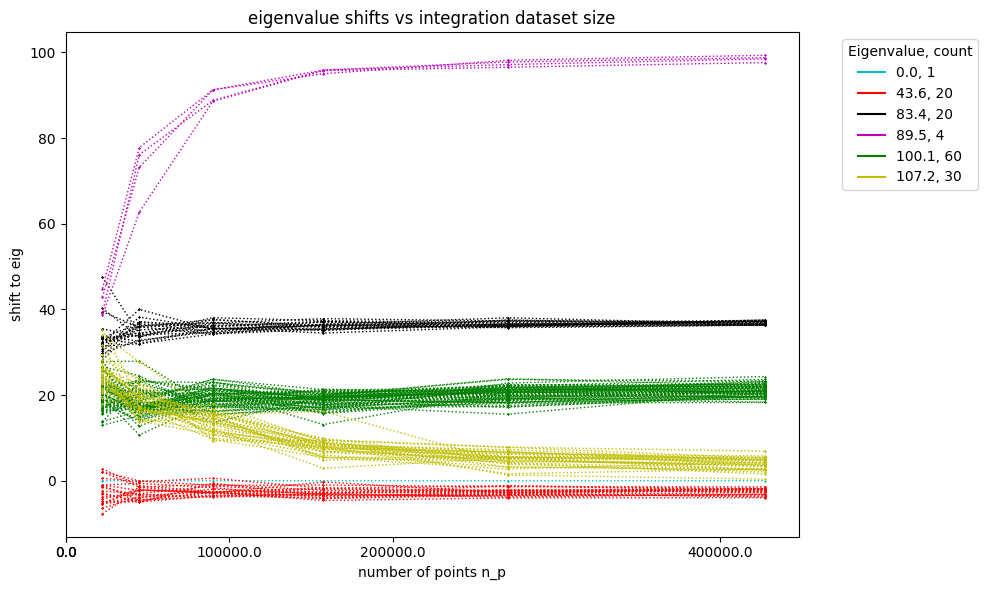

In [178]:
#You can create a separate plot showing the relative shifts (shift / original eigenvalue) to highlight which eigenvalues are most affected by the perturbation.
relative_shifts = tf.math.real(eig_shifts_without_alphaprime[:,:]*(0.03**(0))*(1/(2*np.pi**2))**3)#/ eigvals_all[:,:260])

fig, ax = plt.subplots(figsize=(10, 6))
color_list=['b','g','r','c','m','y','k','aquamarine','mediumseagreen','mediumblue']

for i in range(len(result_clustering[0]['indices'])):#i.e omit the biggest
    #color according to the number from 1 to 10 (i.e. red, green, blue etc)
    index=result_clustering[0]['indices'][i]
    #print(index)
    color= color_list[index]
    mean_val=np.round(result_clustering[index-1]['mean_value'],2)
    #print(color_index)

    ax.plot(numbers_for_plotting[:,i], relative_shifts[:,i],
            marker='x', linestyle='dotted', color=color, linewidth=1, markersize=1)

#label colours as the mean value
for i in range(len(result_clustering)):
    #index=result_clustering[i]['mean_value']
    label_i=result_clustering[i]['group_id']
    ax.plot([], [], color=color_list[label_i], label=str(np.round(result_clustering[i]['mean_value'],1))+ ", "+str(np.round(result_clustering[i]['count'],2)))
#add legend
ax.legend(title='Eigenvalue, count', bbox_to_anchor=(1.05, 1), loc='upper left')

# ax.set_xscale('log')
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_xlabel('number of points n_p')
ax.set_ylabel('shift to eig')
ax.set_title('eigenvalue shifts vs integration dataset size')

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (1225,5) (1225,6) 

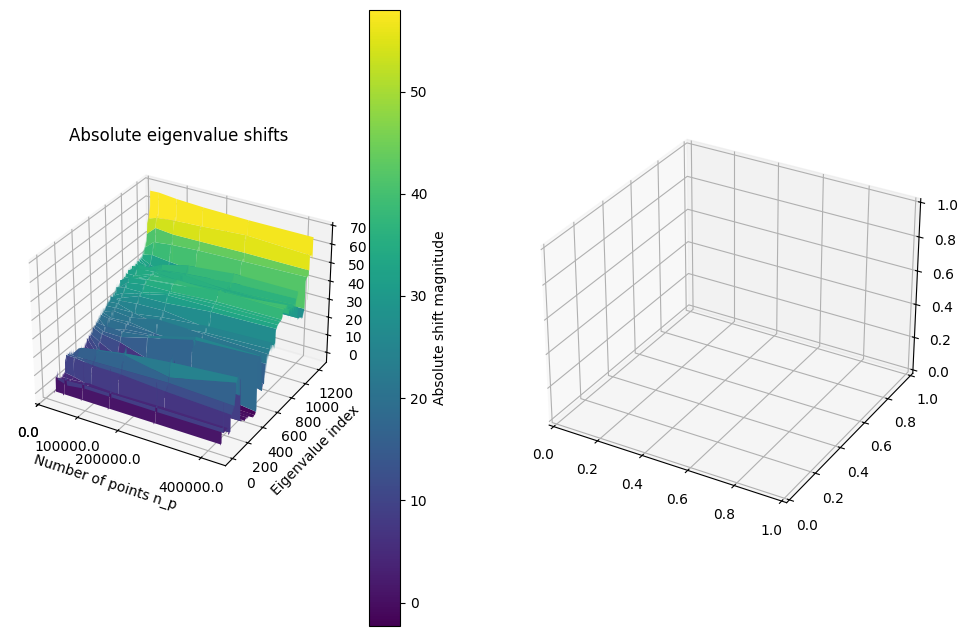

In [182]:
# Create a 3D surface plot to show how the shifts vary across both eigenvalue index and dataset size.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

n_bins = eigvals_all.shape[1]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), subplot_kw={'projection': '3d'})

X, Y = np.meshgrid(numbers_to_take, np.arange(n_bins))

# Plot for absolute shifts
Z_abs = eig_shifts_without_alphaprime.T * 0.03**3
surf1 = ax1.plot_surface(X, Y, Z_abs, cmap='viridis', edgecolor='none')
ax1.set_xlabel('Number of points n_p')
ax1.set_ylabel('Eigenvalue index')
ax1.set_zlabel('Absolute shift magnitude')
ax1.set_title('Absolute eigenvalue shifts')
#ax1.set_xscale('log')
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks)
plt.colorbar(surf1, ax=ax1, label='Absolute shift magnitude')

# Plot for relative shifts
Z_rel = (eig_shifts_without_alphaprime[1:len(numbers_to_take),:].T * 0.03**3) / eigvals_all.T[:, :len(numbers_to_take)]
surf2 = ax2.plot_surface(X, Y, Z_rel, cmap='plasma', edgecolor='none')
ax2.set_xlabel('Number of points n_p')
ax2.set_ylabel('Eigenvalue index')
ax2.set_zlabel('Relative shift magnitude')
ax2.set_title('Relative eigenvalue shifts')
#ax2.set_xscale('log')
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticks)
plt.colorbar(surf2, ax=ax2, label='Relative shift magnitude')

plt.suptitle('Eigenvalue shifts across dataset size and eigenvalue index', fontsize=16)
plt.tight_layout()
plt.show()